# Atmospheric composition distribution by CAMS and GOME-2

### Main goal:
* Compare GOME-2 and CAMS datasets for NO<sub>2</sub>, O<sub>3</sub> and HCHO (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'O3'

# Define sensor
sensor = 'gome'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 0

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2021-09-01'
end_date = '2021-09-02'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In days: ('2021-09-01', '2021-09-02')


## 2. Model data

### Download, read and subset data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds = subset(model_ds, bbox)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 226, longitude: 900, step: 4, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-09-01 2021-09-02
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 ... -0.8 -0.4 -2.033e-13
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-18T07:36 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [7]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Collect and read data as xarray

In [8]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

--2021-09-18 07:36:43--  ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/
           => '.listing'
Resolving acsaf.eoc.dlr.de (acsaf.eoc.dlr.de)... 129.247.254.12
Connecting to acsaf.eoc.dlr.de (acsaf.eoc.dlr.de)|129.247.254.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gome2a/offline/2021/09/01 ... done.
==> PASV ... done.    ==> LIST ... done.

     0K ..                                                     58.9K=0.04s

2021-09-18 07:36:50 (58.9 KB/s) - '.listing' saved [2155]

Removed '.listing'.
Wrote HTML-ized index to 'data/gome/O3/index.html'.
No URLs found in ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/.
File 'data/gome/O3/2021-09-01/A/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20210901013613_051_METOPA_77149_DLR_04.HDF5' already there; not retrieving.
File 'data/gome/O3/2021-09-01/A/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20210901031737_051_METOPA_77150_DLR_04.HDF5' already there; not 

In [9]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, component_nom, satellites)
sensor_ds

/tmp/ipykernel_1840452/1846149447.py:67: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_1840452/1846149447.py:67: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.Dataset>
Dimensions:    (latitude: 360, longitude: 720, time: 2)
Coordinates:
  * latitude   (latitude) float64 -74.76 -74.3 -73.84 ... 87.87 88.78 88.79
  * longitude  (longitude) float64 -180.0 -180.0 -179.0 ... 178.0 179.0 179.0
  * time       (time) datetime64[ns] 2021-09-01 2021-09-02
Data variables:
    O3total    (time, latitude, longitude) float64 nan nan nan ... 292.6 nan nan

## 4. Match data (and apply averaging kernels)

In [10]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR EST. TIME: 2021-09-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2021-09-02T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,time,O3total,delta_time,step_index,model_column
0,-74.755539,-179.999908,2021-09-01,NaN,2021-09-01 12:00:00,2,216.026398
1,-74.755539,-179.999695,2021-09-01,NaN,2021-09-01 12:00:00,2,216.026398
2,-74.755539,-178.999910,2021-09-01,NaN,2021-09-01 12:00:00,2,216.625656
3,-74.755539,-178.999705,2021-09-01,NaN,2021-09-01 12:00:00,2,216.625656
4,-74.755539,-177.999912,2021-09-01,NaN,2021-09-01 12:00:00,2,216.895035
...,...,...,...,...,...,...,...
118795,0.162535,176.999456,2021-09-02,NaN,2021-09-02 12:00:00,2,257.650696
118796,0.162535,177.996603,2021-09-02,NaN,2021-09-02 12:00:00,2,258.140991
118797,0.162535,177.999454,2021-09-02,NaN,2021-09-02 12:00:00,2,258.140991
118798,0.162535,178.996592,2021-09-02,NaN,2021-09-02 12:00:00,2,257.666992


## 5. Merge data and calculate difference

In [11]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

O3total  step_index  model_column  \
latitude   longitude   time                                            
-74.755539 -179.999908 2021-09-01      NaN           2    216.026398   
                       2021-09-02      NaN           2    209.185165   
           -179.999695 2021-09-01      NaN           2    216.026398   
                       2021-09-02      NaN           2    209.185165   
           -178.999910 2021-09-01      NaN           2    216.625656   
...                                    ...         ...           ...   
 0.162535   177.999454 2021-09-02      NaN           2    258.140991   
            178.996592 2021-09-01      NaN           2    257.571625   
                       2021-09-02      NaN           2    257.666992   
            178.999452 2021-09-01      NaN           2    257.571625   
                       2021-09-02      NaN           2    257.666992   

                                   difference  
latitude   longitude   time                    
-74.755539 -179.999908 2021-09-01         NaN  
                       2021-09-02         NaN  
           -179.999695 2021-09-01         NaN  
                       2021-09-02         NaN  
           -178.999910 2021-09-01         NaN  
...                                       ...  
 0.162535   177.999454 2021-09-02         NaN  
            178.996592 2021-09-01         NaN  
                       2021-09-02         NaN  
            178.999452 2021-09-01         NaN  
                       2021-09-02         NaN  

[237600 rows x 4 columns]

In [12]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,O3total,step_index,model_column,difference
count,44577.000000,237600.0,237600.000000,44577.000000
mean,308.178757,2.0,291.210243,7.877878
std,44.826808,0.0,45.422614,11.521916
min,173.034073,2.0,180.851837,-78.059113
25%,278.900620,2.0,266.795853,2.816711
50%,301.213852,2.0,285.695465,6.835861
75%,332.204086,2.0,315.344330,11.839218
max,482.561749,2.0,470.679291,82.174286


## 6. Filtering

In [13]:
#filter_negative = True
#merge_table = filter_merge_table(merge_table, sensor_column, component_nom, units, filter_negative)

## 7. Show comparison plots

### Select plot dates

In [14]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-09' '2021-09']


### Select plot extent

In [15]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 0))


### Compare CAMS and GOME-2 total columns

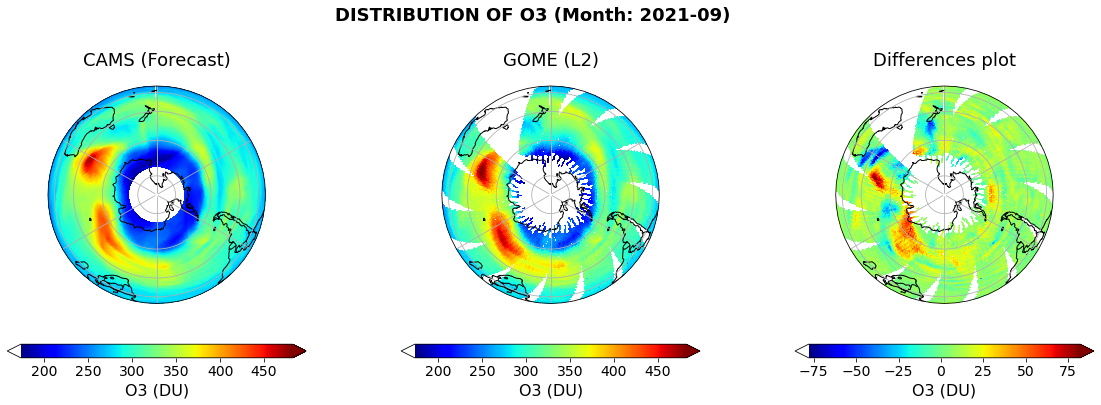

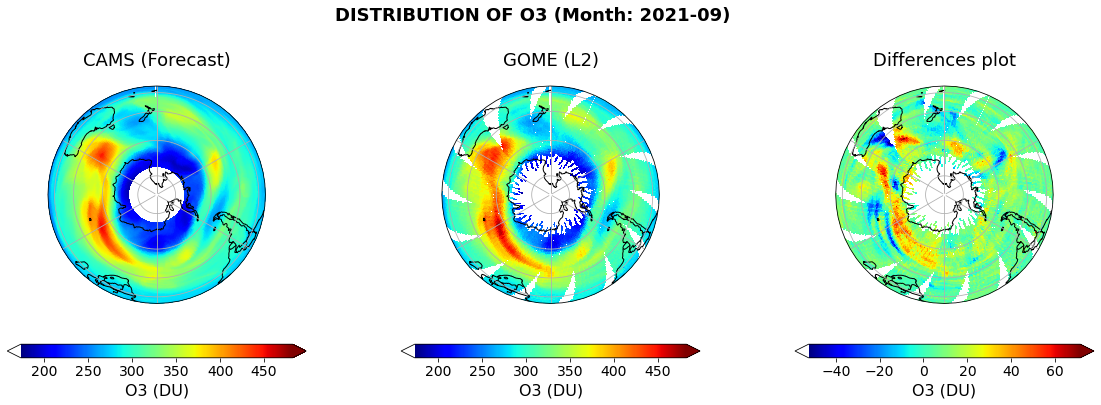

In [16]:
range_type = 'equal' # original or equal
distribution_type = 'individual' # aggregated or individual

#projection = ccrs.PlateCarree()
projection=ccrs.Orthographic(180, -90)
color_scale = 'jet'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.10, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection, 
                          color_scale)

## 8. Retrieve nearest values to specific latitude and longitude

In [17]:
coords_search_list = (-80, 30,
                      -70, 30,
                      -50, 30)
coords_search = pairwise(coords_search_list)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

O3total  step_index  \
lat_search lon_search latitude   longitude time                                 
-80        30         -72.475452 34.998082 2021-09-01  208.040642           2   
                      -72.014634 30.999716 2021-09-02  234.874008           2   
-70        30         -68.831157 28.998144 2021-09-01  228.831192           2   
                      -71.100999 30.999716 2021-09-02  237.433136           2   
-50        30         -49.698606 29.998133 2021-09-01  410.449628           2   
                      -50.087393 29.999718 2021-09-02  433.961922           2   

                                                       model_column  \
lat_search lon_search latitude   longitude time                       
-80        30         -72.475452 34.998082 2021-09-01    204.118118   
                      -72.014634 30.999716 2021-09-02    228.349609   
-70        30         -68.831157 28.998144 2021-09-01    223.570862   
                      -71.100999 30.999716 2021-09-02    230.840088   
-50        30         -49.698606 29.998133 2021-09-01    370.862183   
                      -50.087393 29.999718 2021-09-02    407.216370   

                                                       difference  
lat_search lon_search latitude   longitude time                    
-80        30         -72.475452 34.998082 2021-09-01    3.922523  
                      -72.014634 30.999716 2021-09-02    6.524399  
-70        30         -68.831157 28.998144 2021-09-01    5.260330  
                      -71.100999 30.999716 2021-09-02    6.593048  
-50        30         -49.698606 29.998133 2021-09-01   39.587445  
                      -50.087393 29.999718 2021-09-02   26.745552

## 9. Scatter plots by bbox

Fit equation: O3_model = O3_sensor * 0.94 + (1.18E+01)
Coefficient of determination (R2): 0.93


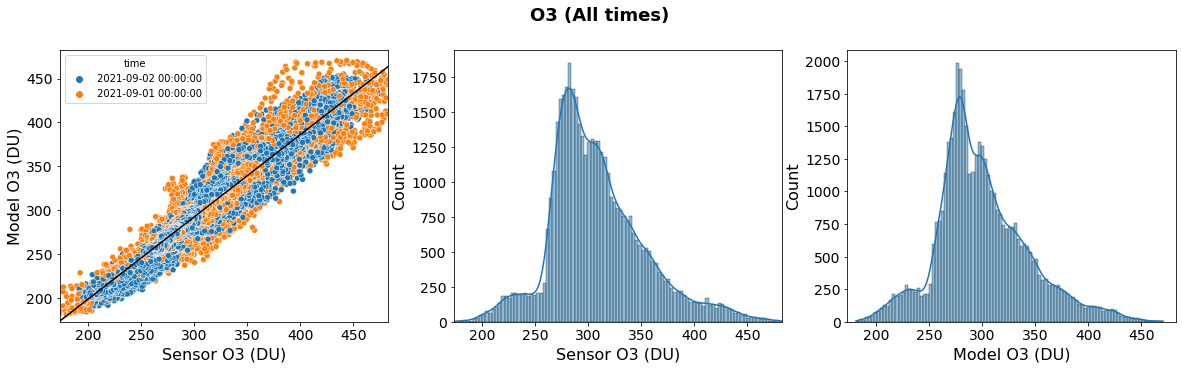

In [18]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [19]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2021-09-01T00:00:00.000000000, 2021-09-02T00:...","((-180, -90), (180, 0))",0.933939,0.936046,11.831357


## 10. Scatter plots by season

Fit equation: O3_model = O3_sensor * 0.94 + (1.18E+01)
Coefficient of determination (R2): 0.93


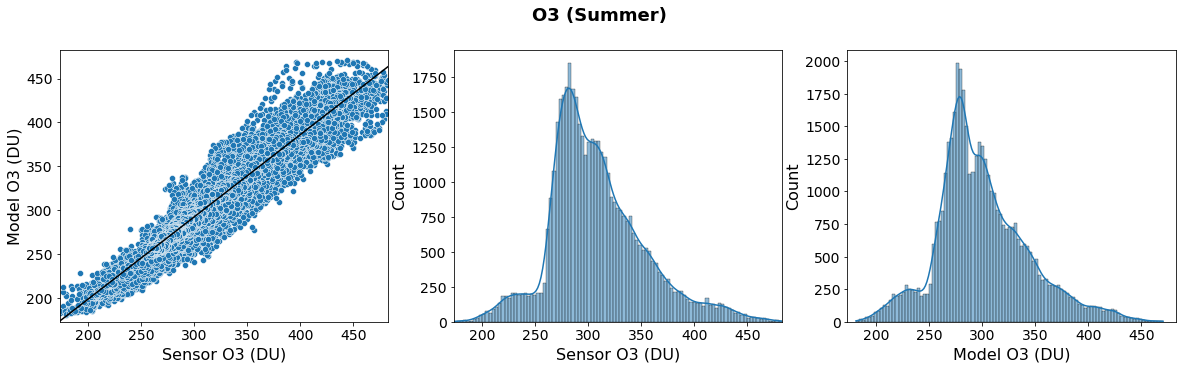

In [20]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [21]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Summer,"((-180, -90), (180, 0))",0.933939,0.936046,11.831357


## 11. Scatter plots by country (Google API required!)

In [22]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [23]:
#summary